## Import Libraries

In [52]:
!pip install evaluate

In [53]:
import pandas as pd
import numpy as np
import torch
from datasets import Dataset, DatasetDict
from transformers import (
    AutoTokenizer, 
    AutoModelForSequenceClassification, 
    TrainingArguments, 
    Trainer, 
    DataCollatorWithPadding,
    AdamW, 
    get_scheduler
)
from sklearn.model_selection import train_test_split
import re
from collections import Counter
from torch.utils.data import DataLoader
from tqdm.auto import tqdm
import torch.nn as nn
import evaluate

## Load Dataset

In [54]:
train_df = pd.read_csv('/kaggle/input/situsjudiid-txt2/text/train.csv')
test_df = pd.read_csv('/kaggle/input/situsjudiid-txt2/text/test.csv')

In [55]:
# Gabungkan train dan test
df = pd.concat([train_df, test_df], ignore_index=True)

In [56]:
df = df[["Extracted Text", "Class"]]
df

,Extracted Text,Class
0,HOME jackpotpartycasinoslotsonline — login pr...,judi
1,r #TOGrt AFATC Situs Online Gaming Terbaik Un...,judi
2,"""€! INFO TERKINI: (TOGEL ONLINE TERBESAR DAN T...",judi
3,Sa TIPE Nomor Ab sernncan 2 Sa HADIAHTOGEL —— ...,judi
4,bet 365 keluaran togel hongkong kemarin HOME ...,judi
...,...,...
2695,J (024) 8316377 MH upgris@upgris.ac.id @UPGRI...,non-judi
2696,Tentang Pendidikan Berita Mahasiswa Penelitian...,non-judi
2697,Kapur 22. at Bookmark — Cari Pengguna . Ld (...,non-judi
2698,... Kam ResepMasakanw — BahanMakanan Kuliner N...,non-judi


## Data Cleaning

In [57]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2700 entries, 0 to 2699
Data columns (total 2 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Extracted Text  2624 non-null   object
 1   Class           2700 non-null   object
dtypes: object(2)
memory usage: 42.3+ KB
None


### Remove Missing Values

In [58]:
# Missing Values Info
print('Count of Missing Values:\n',df.isna().sum())

Count of Missing Values:
 Extracted Text    76
Class              0
dtype: int64


In [59]:
# Menghapus baris dengan missing values
df = df.dropna()

### Remove Duplicated Values

In [60]:
# Duplicated Data
print('Count of Duplicated Data: ', df.duplicated().sum())
df[df.duplicated() == True]

Count of Duplicated Data:  14


,Extracted Text,Class
64,DEPOSIT VIA Kami menggunakan cookies untuk me...,judi
81,RTP SLOT RESMIL LANGSUNG DARI PUSAT Non Red ...,judi
277,Sign up for Tumblr Sign up Discover more blogs...,judi
791,Kategori v (60202388 GO Pulsak Tagihan — WI Vo...,judi
888,TURNAMEN PG SOFT MINGG.. Bonus Setiap Hari - ...,judi
1682,r You pulan konten yang KASKUS liain khusus b...,non-judi
1792,Discover products D LiveChat Product xv Prici...,non-judi
2000,Bisnis Kecantikan Keuangan Otomotif — Pendidik...,non-judi
2193,— $ softonic Berbagai aplikasi terbaik untuk ...,non-judi
2252,Beranda FAO Aplikasi API Moderasi @D- YM Tvi...,non-judi


In [61]:
df = df.drop_duplicates()

### Text Cleaning

In [62]:
df = df.copy()  # Buat salinan sebelum mengubah nilai

In [63]:
import re
from collections import Counter

def clean_text(data):
    temp_text = []
    all_words = []
    
    for text in data:
        # removal of links[https://blabala.com]
        text = re.sub(r"http\S+", "", text)
        # removal of new line
        text = re.sub('\n', '', text)
        # removal of punctuations and numbers
        text = re.sub("[^a-zA-Z^']", " ", text)
        text = re.sub(" {2,}", " ", text)
        # remove leading and trailing whitespace
        text = text.strip()
        # remove whitespace with a single space
        text = re.sub(r'\s+', ' ', text)
        # Remove 1 or 2 letter words
        text = re.sub(r'\b\w{1,2}\b', '', text)
        # Remove words >20 characters
        text = re.sub(r'\b\w{20,}\b', '', text)  
        # convert text to Lowercase
        text = text.lower();

        temp_text.append(text)
        all_words.extend(text.split())

    # Hitung frekuensi kata
    word_counts = Counter(all_words)
    rare_words = {word for word, count in word_counts.items() if count == 1}  # Kata yang muncul 1x

    # Hapus kata yang jarang muncul
    final_texts = []
    for text in temp_text:
        words = text.split()
        cleaned_words = [word for word in words if word not in rare_words]
        final_texts.append(" ".join(cleaned_words))

    return final_texts

In [64]:
df['cleaned_text']=clean_text(df['Extracted Text'])
df.head()

,Extracted Text,Class,cleaned_text
0,HOME jackpotpartycasinoslotsonline — login pr...,judi,home login bigwin jackpot codes
1,r #TOGrt AFATC Situs Online Gaming Terbaik Un...,judi,situs online gaming terbaik untuk gamers langs...
2,"""€! INFO TERKINI: (TOGEL ONLINE TERBESAR DAN T...",judi,info terkini togel online terbesar dan terpeca...
3,Sa TIPE Nomor Ab sernncan 2 Sa HADIAHTOGEL —— ...,judi,tipe nomor mimpi imei referral ieee hubungi kami
4,bet 365 keluaran togel hongkong kemarin HOME ...,judi,bet keluaran togel hongkong kemarin home apk t...


In [65]:
df['Class'] = df['Class'].apply(lambda x: 1 if x == 'judi' else 0)
df.head()

,Extracted Text,Class,cleaned_text
0,HOME jackpotpartycasinoslotsonline — login pr...,1,home login bigwin jackpot codes
1,r #TOGrt AFATC Situs Online Gaming Terbaik Un...,1,situs online gaming terbaik untuk gamers langs...
2,"""€! INFO TERKINI: (TOGEL ONLINE TERBESAR DAN T...",1,info terkini togel online terbesar dan terpeca...
3,Sa TIPE Nomor Ab sernncan 2 Sa HADIAHTOGEL —— ...,1,tipe nomor mimpi imei referral ieee hubungi kami
4,bet 365 keluaran togel hongkong kemarin HOME ...,1,bet keluaran togel hongkong kemarin home apk t...


In [66]:
textdf = df[['cleaned_text', 'Class']]
textdf

,cleaned_text,Class
0,home login bigwin jackpot codes,1
1,situs online gaming terbaik untuk gamers langs...,1
2,info terkini togel online terbesar dan terpeca...,1
3,tipe nomor mimpi imei referral ieee hubungi kami,1
4,bet keluaran togel hongkong kemarin home apk t...,1
...,...,...
2695,upgris upgris upgris profil fakultas timur sem...,0
2696,tentang pendidikan berita mahasiswa penelitian...,0
2697,bookmark cari pengguna today' highlight atau mena,0
2698,kam kuliner nutrisi tips event cari resep dan ...,0


## Split Dataset

In [67]:
import random
def set_seed(seed: int):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  # jika menggunakan GPU
    torch.backends.cudnn.deterministic = True  # Meningkatkan determinisme
    torch.backends.cudnn.benchmark = False   # Hindari optimisasi performa yang mungkin non-deterministik

set_seed(42)

In [68]:
from datasets import Dataset
# Pisahkan 70% data sebagai train, sisanya 30% sebagai temp
train_texts, temp_texts, train_labels, temp_labels = train_test_split(
    textdf['cleaned_text'].tolist(), textdf['Class'].tolist(), test_size=0.3, random_state=42
)

# Pisahkan temp menjadi validation (15%) dan test (15%)
val_texts, test_texts, val_labels, test_labels = train_test_split(
    temp_texts, temp_labels, test_size=0.5, random_state=42
)

# Konversi ke format Hugging Face
dataset = DatasetDict({
    "train": Dataset.from_dict({"text": train_texts, "label": train_labels}),
    "validation": Dataset.from_dict({"text": val_texts, "label": val_labels}),
    "test": Dataset.from_dict({"text": test_texts, "label": test_labels})
})

In [69]:
# Load IndoBERT tokenizer
checkpoint = "indobenchmark/indobert-base-p2"
tokenizer = AutoTokenizer.from_pretrained(checkpoint, use_fast=True)

In [70]:
# Fungsi tokenisasi
def tokenize_function(examples):
    return tokenizer(examples["text"], truncation=True, padding="max_length", max_length=128)

tokenized_datasets = dataset.map(tokenize_function, batched=True)

# Hapus kolom yang tidak diperlukan
tokenized_datasets = tokenized_datasets.remove_columns(["text"])

# Ubah nama kolom "label" menjadi "labels"
tokenized_datasets = tokenized_datasets.rename_column("label", "labels")

# Atur format ke PyTorch
tokenized_datasets.set_format("torch")

Map:   0%|          | 0/1827 [00:00<?, ? examples/s]

Map:   0%|          | 0/391 [00:00<?, ? examples/s]

Map:   0%|          | 0/392 [00:00<?, ? examples/s]

In [71]:
# DataLoader
batch_size = 16
data_collator = DataCollatorWithPadding(tokenizer)

# Fungsi untuk memastikan setiap worker memiliki seed yang sama
def seed_worker(worker_id):
    worker_seed = torch.initial_seed() % 2**32
    np.random.seed(worker_seed)
    random.seed(worker_seed)

# Generator untuk DataLoader
g = torch.Generator()
g.manual_seed(42)  # Sesuaikan seed agar konsisten

# DataLoader menggunakan dataset yang sudah di-tokenisasi
# DataLoader dengan seed-controlled workers
train_dataloader = DataLoader(
    tokenized_datasets["train"], 
    shuffle=True, 
    batch_size=batch_size, 
    collate_fn=data_collator,
    num_workers=4,  # Sesuaikan dengan jumlah CPU cores yang tersedia
    worker_init_fn=seed_worker, 
    generator=g
)

val_dataloader = DataLoader(
    tokenized_datasets["validation"], 
    batch_size=batch_size, 
    collate_fn=data_collator,
    num_workers=4,
    worker_init_fn=seed_worker,
    generator=g
)

test_dataloader = DataLoader(
    tokenized_datasets["test"], 
    batch_size=batch_size, 
    collate_fn=data_collator,
    num_workers=4,
    worker_init_fn=seed_worker,
    generator=g
)

In [72]:
num_labels = 1  # Hanya 1 neuron untuk binary classification

class CustomIndoBERT(nn.Module):
    def __init__(self, checkpoint, num_labels=num_labels):
        super(CustomIndoBERT, self).__init__()
        self.model = AutoModelForSequenceClassification.from_pretrained(checkpoint, num_labels=num_labels)
        self.dropout = nn.Dropout(0.2)
        self.classifier = nn.Linear(self.model.config.hidden_size, num_labels)  # Ubah jadi 1 neuron
    
    def forward(self, input_ids, attention_mask, labels=None):
        outputs = self.model.bert(input_ids=input_ids, attention_mask=attention_mask)
        pooled_output = outputs.pooler_output
        x = self.dropout(pooled_output)
        logits = self.classifier(x).squeeze(1)  # Squeeze agar output jadi [batch_size]
        
        loss = None
        if labels is not None:
            loss_fn = nn.BCEWithLogitsLoss()
            loss = loss_fn(logits, labels.float())  # Pastikan labels bertipe float
        
        return {'loss': loss, 'logits': logits}

In [73]:
# # Initialize model
# model = CustomIndoBERT(checkpoint)
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# model.to(device)

# # Optimizer and Scheduler
# optimizer = AdamW(model.parameters(), lr=5e-5)
# num_epochs = 3
# num_training_steps = num_epochs * len(train_dataloader)
# lr_scheduler = get_scheduler("linear", optimizer=optimizer, num_warmup_steps=0, num_training_steps=num_training_steps)


In [74]:
# import torch.nn.functional as F

# # Training loop
# progress_bar = tqdm(range(num_training_steps))
# model.train()
# for epoch in range(num_epochs):
#     for batch in train_dataloader:
#         batch = {k: v.to(device) for k, v in batch.items() if k != "token_type_ids"}  # Hapus token_type_ids
#         outputs = model(**batch)
#         loss = outputs['loss']
#         loss.backward()
#         optimizer.step()
#         lr_scheduler.step()
#         optimizer.zero_grad()
#         progress_bar.update(1)

In [80]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.optim.lr_scheduler import LambdaLR
from tqdm import tqdm
import matplotlib.pyplot as plt

# Initialize model
model = CustomIndoBERT(checkpoint)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Hyperparameters
learning_rates = [1e-5, 3e-5, 5e-5]  # Eksperimen dengan 3 learning rate
num_epochs = 3
patience = 3  # Jika val_loss tidak membaik setelah 3 epoch, training berhenti

# Loss function
criterion = nn.BCEWithLogitsLoss()

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [81]:
def train_and_evaluate(model, train_dataloader, val_dataloader, test_dataloader, lr):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    optimizer = optim.AdamW(model.parameters(), lr=lr)
    criterion = nn.BCEWithLogitsLoss()
    
    best_val_loss = float('inf')
    best_model_wts = copy.deepcopy(model.state_dict())
    early_stop_counter = 0
    
    history = {'loss': [], 'val_loss': [], 'accuracy': [], 'val_accuracy': []}
    
    for epoch in range(num_epochs):
        model.train()
        running_loss, correct, total = 0.0, 0, 0
        train_loader_tqdm = tqdm(train_dataloader, desc=f"LR {lr} - Epoch {epoch+1}/{num_epochs}")
        
        for batch in train_loader_tqdm:
            batch = {k: v.to(device) for k, v in batch.items() if k != "token_type_ids"}
            labels = batch['labels'].float()
            optimizer.zero_grad()
            
            outputs = model(**batch)['logits']
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            predicted = (torch.sigmoid(outputs) > 0.5).float()
            correct += (predicted == labels).sum().item()
            total += labels.size(0)
            
            train_loader_tqdm.set_postfix(loss=loss.item(), acc=correct/total)
        
        train_loss = running_loss / len(train_dataloader)
        train_acc = correct / total
        
        # Validation
        model.eval()
        val_loss, correct, total = 0.0, 0, 0
        with torch.no_grad():
            for batch in val_dataloader:
                batch = {k: v.to(device) for k, v in batch.items() if k != "token_type_ids"}
                labels = batch['labels'].float()
                outputs = model(**batch)['logits']
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                predicted = (torch.sigmoid(outputs) > 0.5).float()
                correct += (predicted == labels).sum().item()
                total += labels.size(0)
        
        val_loss /= len(val_dataloader)
        val_acc = correct / total
        
        print(f"LR {lr} - Epoch {epoch+1}/{num_epochs} | Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f} | Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f}")
        
        history['loss'].append(train_loss)
        history['accuracy'].append(train_acc)
        history['val_loss'].append(val_loss)
        history['val_accuracy'].append(val_acc)
        
        # Checkpointing
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model_wts = copy.deepcopy(model.state_dict())
            torch.save(model.state_dict(), f'best_model_lr_{lr}.pth')
            early_stop_counter = 0  # Reset counter jika ada perbaikan
        else:
            early_stop_counter += 1
            if early_stop_counter >= patience:
                print(f"Early stopping at epoch {epoch+1} for LR {lr}")
                break
    
    # Load best model
    model.load_state_dict(best_model_wts)
    
    # Evaluate on test set
    model.eval()
    test_loss, correct, total = 0.0, 0, 0
    with torch.no_grad():
        for batch in test_dataloader:
            batch = {k: v.to(device) for k, v in batch.items() if k != "token_type_ids"}
            labels = batch['labels'].float()
            outputs = model(**batch)['logits']
            loss = criterion(outputs, labels)
            test_loss += loss.item()
            predicted = (torch.sigmoid(outputs) > 0.5).float()
            correct += (predicted == labels).sum().item()
            total += labels.size(0)
    
    test_loss /= len(test_dataloader)
    test_acc = correct / total
    
    print(f"Best Model for LR {lr} | Test Loss: {test_loss:.4f} | Test Acc: {test_acc:.4f}")
    return test_loss, test_acc, history

In [82]:
import copy
# Jalankan eksperimen untuk setiap learning rate
results = {}
for lr in learning_rates:
    model = CustomIndoBERT(checkpoint)  # Reset model setiap kali
    results[lr] = train_and_evaluate(model, train_dataloader, val_dataloader, test_dataloader, lr)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
LR 1e-05 - Epoch 1/3: 100%|██████████| 115/115 [00:41<00:00,  2.74it/s, acc=0.913, loss=0.0157]


LR 1e-05 - Epoch 1/3 | Train Loss: 0.2264 | Train Acc: 0.9130 | Val Loss: 0.1101 | Val Acc: 0.9616


LR 1e-05 - Epoch 2/3: 100%|██████████| 115/115 [00:43<00:00,  2.65it/s, acc=0.974, loss=0.0135] 


LR 1e-05 - Epoch 2/3 | Train Loss: 0.0717 | Train Acc: 0.9743 | Val Loss: 0.0994 | Val Acc: 0.9616


LR 1e-05 - Epoch 3/3: 100%|██████████| 115/115 [00:42<00:00,  2.68it/s, acc=0.986, loss=0.00442]


LR 1e-05 - Epoch 3/3 | Train Loss: 0.0430 | Train Acc: 0.9858 | Val Loss: 0.1326 | Val Acc: 0.9565
Best Model for LR 1e-05 | Test Loss: 0.0994 | Test Acc: 0.9694


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
LR 3e-05 - Epoch 1/3: 100%|██████████| 115/115 [00:42<00:00,  2.68it/s, acc=0.932, loss=0.013] 


LR 3e-05 - Epoch 1/3 | Train Loss: 0.1803 | Train Acc: 0.9316 | Val Loss: 0.1036 | Val Acc: 0.9565


LR 3e-05 - Epoch 2/3: 100%|██████████| 115/115 [00:43<00:00,  2.67it/s, acc=0.975, loss=0.00503]


LR 3e-05 - Epoch 2/3 | Train Loss: 0.0611 | Train Acc: 0.9748 | Val Loss: 0.1633 | Val Acc: 0.9514


LR 3e-05 - Epoch 3/3: 100%|██████████| 115/115 [00:42<00:00,  2.68it/s, acc=0.985, loss=0.00152]


LR 3e-05 - Epoch 3/3 | Train Loss: 0.0356 | Train Acc: 0.9852 | Val Loss: 0.1832 | Val Acc: 0.9488
Best Model for LR 3e-05 | Test Loss: 0.1066 | Test Acc: 0.9541


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
LR 5e-05 - Epoch 1/3: 100%|██████████| 115/115 [00:42<00:00,  2.68it/s, acc=0.92, loss=0.00447] 


LR 5e-05 - Epoch 1/3 | Train Loss: 0.2028 | Train Acc: 0.9201 | Val Loss: 0.1480 | Val Acc: 0.9437


LR 5e-05 - Epoch 2/3: 100%|██████████| 115/115 [00:43<00:00,  2.67it/s, acc=0.973, loss=0.00431]


LR 5e-05 - Epoch 2/3 | Train Loss: 0.0781 | Train Acc: 0.9726 | Val Loss: 0.1907 | Val Acc: 0.9309


LR 5e-05 - Epoch 3/3: 100%|██████████| 115/115 [00:43<00:00,  2.67it/s, acc=0.984, loss=0.000768]


LR 5e-05 - Epoch 3/3 | Train Loss: 0.0428 | Train Acc: 0.9836 | Val Loss: 0.1758 | Val Acc: 0.9591
Best Model for LR 5e-05 | Test Loss: 0.1520 | Test Acc: 0.9337


In [83]:
# Bandingkan hasil terbaik
best_lr = min(results, key=lambda x: results[x][0])  # Pilih LR dengan test acc tertinggi
print(f"Best Learning Rate: {best_lr} | Test Loss: {results[best_lr][0]:.4f} | Test Accuracy: {results[best_lr][1]:.4f}")

Best Learning Rate: 1e-05 | Test Loss: 0.0994 | Test Accuracy: 0.9694


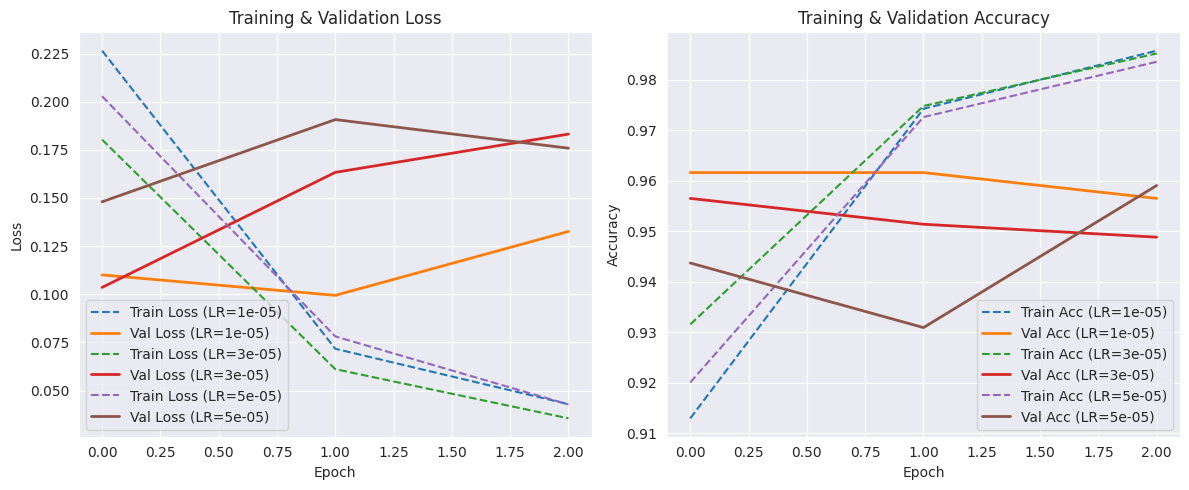

In [84]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_training_history(results):
    sns.set_style("darkgrid")
    
    plt.figure(figsize=(12, 5))
    
    # Subplot 1: Training & Validation Loss
    plt.subplot(1, 2, 1)
    for lr, (test_loss, test_acc, history) in results.items():  # Unpack tuple
        plt.plot(history["loss"], label=f"Train Loss (LR={lr})", linestyle="--")
        plt.plot(history["val_loss"], label=f"Val Loss (LR={lr})", linewidth=2)
    
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Training & Validation Loss")
    plt.legend()
    
    # Subplot 2: Training & Validation Accuracy
    plt.subplot(1, 2, 2)
    for lr, (test_loss, test_acc, history) in results.items():  # Unpack tuple
        plt.plot(history["accuracy"], label=f"Train Acc (LR={lr})", linestyle="--")
        plt.plot(history["val_accuracy"], label=f"Val Acc (LR={lr})", linewidth=2)
    
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.title("Training & Validation Accuracy")
    plt.legend()
    
    plt.tight_layout()
    plt.show()

# Panggil fungsi setelah training selesai
plot_training_history(results)
